In [1]:
# import library

import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import cv2

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# import dataset

from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)
data_dir = '/content/gdrive/MyDrive/Colab Notebooks/skripsi/dataset'
print(data_dir)

Mounted at /content/gdrive
/content/gdrive/MyDrive/Colab Notebooks/skripsi/dataset


In [ ]:
labels = ['', 'soccer']
img_size = 224
def get_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] #convert BGR to RGB format
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
train_ds = ImageDataGenerator(rescale = 1./255,
    zoom_range = 0.2,
    horizontal_flip = True,
    vertical_flip=True,
    rotation_range=90,
)

val_ds = ImageDataGenerator(rescale = 1./255)

In [5]:
img_height,img_width=224,224
batch_size=32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 100 files belonging to 2 classes.
Using 80 files for training.
Found 100 files belonging to 2 classes.
Using 20 files for validation.


In [6]:
# identifikasi class

class_names = train_ds.class_names
print(class_names)

['batik-garutan', 'batik-lain']


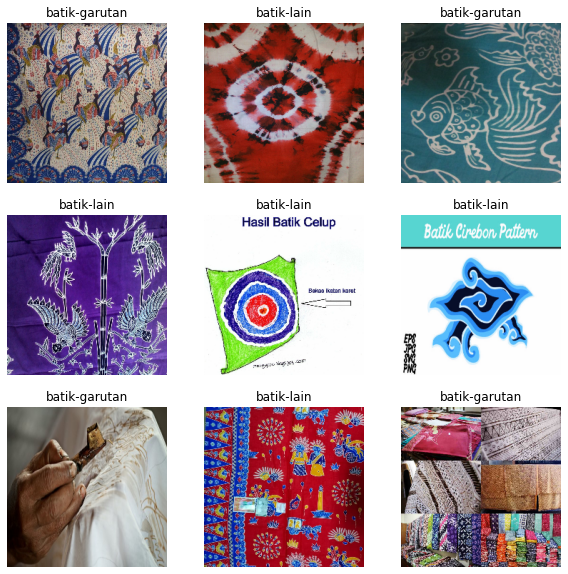

In [8]:
# visualisasi data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
resnet_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224,224,3),
    pooling='avg',
    classes=2,
    weights='imagenet'
    )

for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

94781440/94765736 [==============================] - 1s 0us/step


In [10]:
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(1, activation='sigmoid'))

In [11]:
resnet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 24,637,313
Trainable params: 1,049,601
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
resnet_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
    )

history = resnet_model.fit(
    train_ds, 
    validation_data=val_ds, 
    epochs=10
    )

Epoch 1/10
3/3 [==============================] - 24s 7s/step - loss: 1.4836 - accuracy: 0.4125 - val_loss: 1.6137 - val_accuracy: 0.6500
Epoch 2/10
3/3 [==============================] - 16s 5s/step - loss: 0.4013 - accuracy: 0.8500 - val_loss: 0.7819 - val_accuracy: 0.8000
Epoch 3/10
3/3 [==============================] - 16s 5s/step - loss: 0.1320 - accuracy: 0.9375 - val_loss: 0.6300 - val_accuracy: 0.8500
Epoch 4/10
3/3 [==============================] - 16s 5s/step - loss: 0.0595 - accuracy: 0.9750 - val_loss: 0.7131 - val_accuracy: 0.8000
Epoch 5/10
3/3 [==============================] - 16s 5s/step - loss: 0.0258 - accuracy: 0.9875 - val_loss: 0.7670 - val_accuracy: 0.7500
Epoch 6/10
3/3 [==============================] - 16s 5s/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.7876 - val_accuracy: 0.8000
Epoch 7/10
3/3 [==============================] - 16s 5s/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 0.7797 - val_accuracy: 0.8000
Epoch 8/10
3/3 [==================

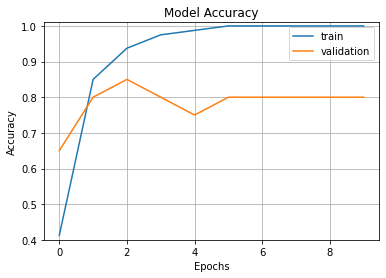

In [13]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1.01)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

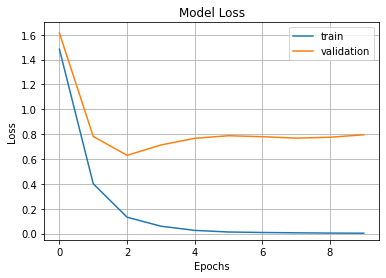

In [15]:
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=-0.05,ymax=1.7)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
predictions = resnet_model.predict_classes(x_val)
predictions = predictions.reshape(1,-1)[0]

print(classification_report(y_val, predictions, target_names = ['Rugby (Class 0)','Soccer (Class 1)']))